## Introduction 

Forecasting inbound tourism demand is crucial for Thailand, where tourism contributes approximately 12% of GDP and employs over 20% of the workforce [@suthiwartnarueput2024thai]. Accurate forecasts help Thai government agencies and the tourism industry optimize resource allocation, improve policy decisions and enhance strategic planning [@song2003modelling]. However, predicting tourism demand is challenging due to seasonality, volatility and non-linearity in the data, further exacerbated by external shocks such as COVID-19 [@gossling2020pandemics]. Traditional statistical methods like Autoregressive Integrated Moving Average (ARIMA) and Exponential Smoothing (ETS) have been widely used in tourism forecasting, including for Thailand [@intarapak2022classical]. While these methods are computationally efficient and interpretable, they often struggle to model complex temporal dependencies [@hyndman2021forecasting], making it an opportunity to explore more advanced approaches. Deep Learning models, particularly Recurrent Neural Networks (RNN), have shown promise in time series forecasting due to their ability to capture sequential dependencies [@Goodfellow2016]. Their strong performance in forecasting competitions such as the M4 [@makridakis2018m4] has further driven interest in their application to Thai tourism data [@kosungnoen2024comparative]. In this study, results demonstrate that RNN exhibits robust predictive power even with just 110 training observations, highlighting their potential. This research evaluates the effectiveness of different RNN units within a stacked architecture for univariate forecasting of inbound tourist demand in Thailand, implemented using Python.

## Univariate Time Series Forecasting

Univariate time series forecasting (UTSF) focuses on predicting future values using only past observations of a single variable—in this case, the number of inbound tourists.

Mathematically, the forecasting problem (@eq-utsf) can be formulated as:

$$
\hat{Y}_{t+1} = f(y_t, y_{t-1}, \dots, y_{t-n})
$$ {#eq-utsf}

where $\hat{Y}_{t+1}$ is the predicted number of inbound tourists at time $t+1$, $y_t, y_{t-1}, \dots, y_{t-n}$ represent the past $n$ observations of tourist arrivals, and $f(\cdot)$ is a function that models the relationship between past and future values. UTSF is computationally efficient and useful when external data is scarce or unreliable. However, it does not capture interactions between external drivers and the target variable, potentially limiting forecasting accuracy [@Athanasopoulos2012]. Despite this limitation, focusing on UTSF is of fundamental importance as it establishes a baseline for comparison, which is essential before exploring more advanced methods that incorporate external factors. Here, the focus is on a 3-step ahead forecast horizon, which is widely used in short-term forecasting and provides valuable insights for decision-makers and policymakers who base their quarterly planning on such forecasts, setting a rigorous stage for further research.

## Dataset Overview

The dataset detailing the number of foreign tourists visiting Thailand is sourced from the official website of the Bank of Thailand, with data provided by the Economic Tourism and Sports Division, Ministry of Tourism and Sports [@BoT_nodate]. The Inbound Tourism Statistics of Thailand dataset consists of monthly records that are updated regularly. @fig-inbound-tourists-th-plot presents a univariate time series plot of inbound tourist arrivals spanning from January 2015 to August 2024, encompassing a total of 116 observations.

In [1]:
# load required libraries
import pandas as pd
import numpy as np
import io

# Load the CSV, skipping metadata rows
file_path = './dataset/thai_inbound_tourists.csv'
th_tourist_demand_df = pd.read_csv(file_path, 
                         encoding='TIS-620', 
                         skiprows=5, 
                         header=None)

# Set the first row as column headers
th_tourist_demand_df.columns = th_tourist_demand_df.iloc[0]  # Assign first row as headers
th_tourist_demand_df = th_tourist_demand_df[1:].reset_index(drop=True)  # Drop the first row

# Extract the row corresponding to "Number of foreign tourists visiting Thailand"
tourists_row = th_tourist_demand_df.iloc[0]  # First row after the header row

# Extract the month-year values as the index and clean them
month_years = tourists_row.iloc[2:].index.astype(str) \
               .str.strip() \
               .str.replace(r'\s*[a-zA-Z]$', '', 
                regex=True)  # remove trailing single letters like 'r', 'p',

# Convert the values to a time series with the correct datetime index
th_tourists_set = pd.Series(
    tourists_row.iloc[2:].values,
    index=pd.to_datetime(month_years, format='%b %Y'),
    name="Inbound Tourists to Thailand (in thousands)"
).astype(float)

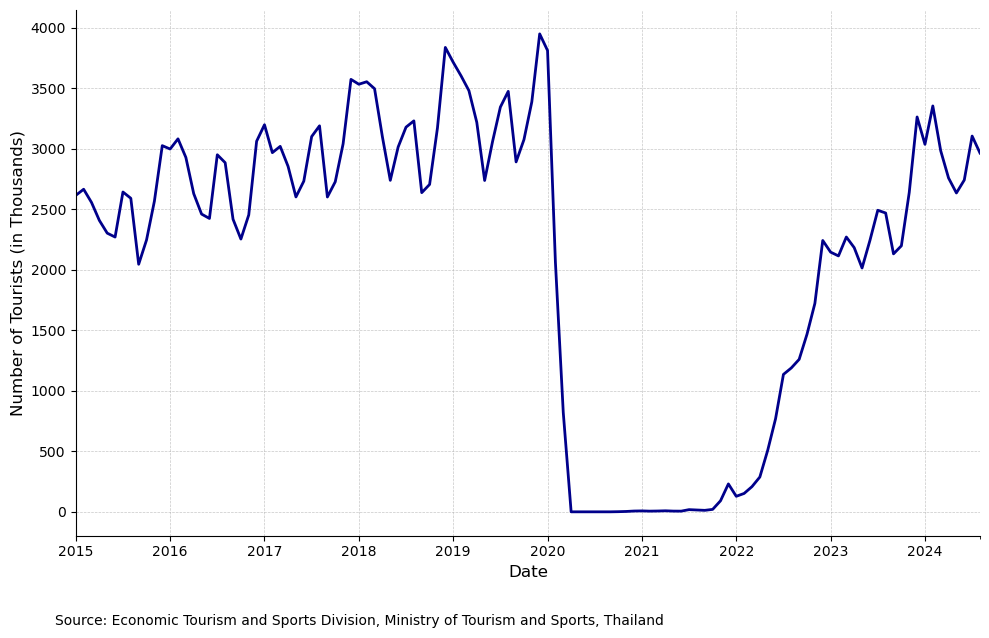

In [2]:
#| warning: false
#| echo: false
#| label: fig-inbound-tourists-th-plot
#| fig-cap: "Inbound Tourists to Thailand (in Thousands)"

# Import plotting libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the time series
th_tourists_set.plot(ax=ax, color='darkblue', 
                        linewidth=2, label="Inbound Tourists")

# Formatting title and labels
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Number of Tourists (in Thousands)", fontsize=12)

# Set x-axis date formatting
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=6))  # Minor ticks at mid-year

# Rotate x-axis labels for better visibility
plt.xticks(fontsize=10)

# Add grid with subtle styling
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Remove top and right spines for a cleaner look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Adding annotations below the figure
plt.figtext(0.06, -0.05, 
            'Source: Economic Tourism and Sports Division, Ministry of Tourism and Sports, Thailand',
            ha='left', fontsize=10)

# Optimize layout
plt.tight_layout()

# Show the plot
plt.show()

## Data Preprocessing

Preprocessing is a fundamental step in time series forecasting, extensively highlighted in the literature to ensure the robustness and reliability of model performance, particularly when working with RNN. @fig-diagram-1-preprocessing illustrates the core preprocessing steps adopted in this study, which align with methodologies proposed by Bandara et al. [-@Bandara2020] and Hewamalage et al. [-@Hewamalage2021].

::: {#fig-diagram-1-preprocessing fig-pos='H'}

![](preprocess-flowchart.png)

diagram illustrating the key data preprocessing steps undertaken.
:::

### Data Splitting

Following the methodology outlined by Hewamalage et al. [-@Hewamalage2021], the time series is divided into training, validation and test sets to ensure a structured evaluation. The most recent portion, corresponding to the 3-step ahead forecast horizon, is reserved as the test set. The validation set consists of the final segment of the remaining data, also matching the 3-step ahead forecast horizon in length. The rest of the series, comprising 110 observations, is used for training. This fixed-origin validation approach enables effective hyperparameter tuning, as described in @sec-hyperparameters-tuning. Instead of a rolling origin scheme, this method is chosen to align with standard competition frameworks and facilitate meaningful comparisons with both existing and newer research. After selecting the optimal hyperparameters, the model is retrained on the entire dataset (excluding only the unseen test set) and then evaluated on this final test set to provide an unbiased assessment of its forecasting performance.

In [3]:
#--------------------

# Split Dataset

#--------------------

# Define helper function to split the dataset
def split_dataset(original_series, h):
    """
    Splits the time series into training and test sets 
    based on the forecast horizon.

    Parameters:
    - original_series (pd.Series): The original time series data.
    - h (int): Forecast horizon (size of the test set).

    Returns:
    - train_set (pd.Series): The training set.
    - test_set (pd.Series): The test set.
    """
    
    # Ensure the series is sorted in ascending order by date
    original_series = original_series.sort_index(ascending=True)

    # Length of the series
    l = len(original_series)
    
    # The most recent `h` points are the test set
    test_set = original_series[-h:]
    
    # Training set: all data before the test set
    train_set = original_series[:-h]
    
    return train_set, test_set

# Forecast horizon (size of test set)
h = 3

# Split the dataset
train_set, test_set = split_dataset(th_tourists_set, h)

### Modelling Seasonality and Trend {#sec-modelling-seasonality-trend}

In my approach, I consider findings in the literature indicating that deep learning methods are often less effective at directly modeling seasonality in time series data, as highlighted by Nelson et al. [-@nelson1999time], Zhang & Qi [-@zhang2005neural], Zhang & Kline [-@zhang2007quarterly], Claveria et al. [-@claveria2017datapreprocessing] and Smyl [-@smyl2020hybrid]. These studies suggest that removing seasonality before applying neural networks (NNs) can enhance forecasting performance. However, a few studies [e.g., @tang1991time;@sharda1992connectionist] argue that NNs can successfully model seasonality without the need for deseasonalization. Nevertheless, given the larger body of literature favoring deseasonalization and the empirical evidence from tourism demand forecasting, I choose to follow the approach of removing seasonality prior to feeding the data into the neural networks. While variance stabilization is generally recommended before decomposing the series, using transformations like the log and box-cox, these approaches were tested in this study and deemed inappropriate, therefore keeping the data as is. To extract seasonal and trend components, I use the `statsmodels` implementation of the STL method [@cleveland1990stl; @perktold2024statsmodels], setting the season parameter to `13` to capture seasonality correctly for monthly time series. The robust option is activated to apply a data-dependent weighting function during the Local Polynomial Regression (LOWESS) estimation [@cleveland1979robust]. This robust estimation is particularly useful for identifying and mitigating outliers, such as those introduced by the COVID-19 pandemic, which can be handled further in the residuals, as highlighted by Hyndman et al. [-@hyndman2021forecasting]. The decomposition results are illustrated in @fig-stl-decomposition-plot, which provides a breakdown of the original series into its trend, seasonal and residual components. For managing the trend, I follow the approach of Bandara et al. [-@Bandara2020] and Hewamalage et al. [-@Hewamalage2021]. Specifically, in the moving window strategy (detailed in @sec-moving-strategy), I subtract the last trend value in each input window from all points in the corresponding input and output windows. This per-window local normalization prevents activation function saturation [@Hewamalage2021], allowing the RNN to model the trend directly without requiring separate trend modeling, thus simplifying the overall approach [@Bandara2020].

In [4]:
#--------------------

# Apply STL decomposition

#--------------------

# Import STL method from statsmodels (Perktold 2024) 
from statsmodels.tsa.seasonal import STL

# Define STL decomposition function
def apply_stl_decomposition(series, period):
    """
    Applies STL decomposition to a time series using LOWESS.

    Parameters:
    - series (pd.Series): The original time series.
    - period (int): The seasonal period (13 for monthly data).

    Returns:
    - trend (pd.Series): Trend component.
    - seasonal (pd.Series): Seasonal component.
    - residual (pd.Series): Residual component.
    """
    stl = STL(series, period=period, robust=True)
    stl_result = stl.fit()  # Apply the STL decomposition
    return stl_result.trend, stl_result.seasonal, stl_result.resid

# Apply STL decomposition to the tourist data (with a seasonal period of 13)
trend, seasonal, residuals = apply_stl_decomposition(train_set, period=13)

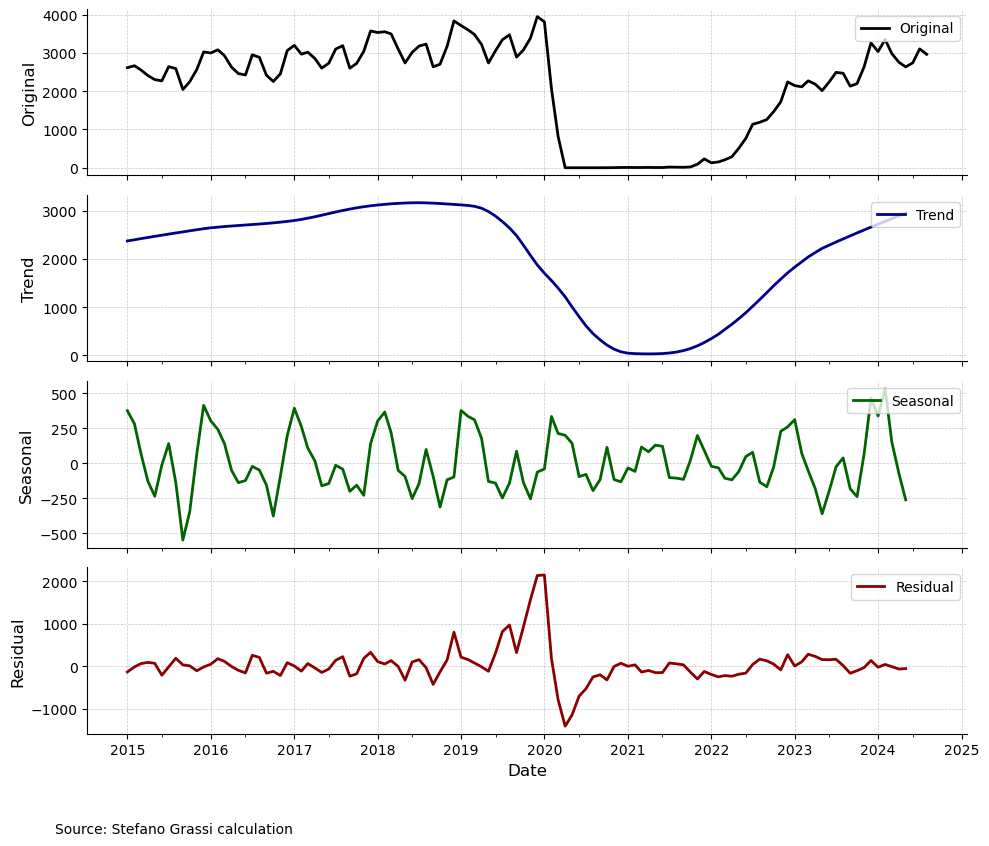

In [5]:
#| echo: false
#| label: fig-stl-decomposition-plot
#| fig-cap: "STL decomposition of the training dataset"

# Create the figure and subplots
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

# Define colors for consistency
colors = ["black", "darkblue", "darkgreen", "darkred"]
labels = ["Original", "Trend", "Seasonal", "Residual"]
series = [th_tourists_set, trend, seasonal, residuals]

for ax, data, label, color in zip(axes, series, labels, colors):
    ax.plot(data, color=color, linewidth=2, label=label)
    ax.set_ylabel(label, fontsize=12)
    ax.legend(loc="upper right", fontsize=10)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    
# Set x-axis formatting
axes[-1].set_xlabel("Date", fontsize=12)
axes[-1].xaxis.set_minor_locator(mdates.MonthLocator(bymonth=6))
plt.xticks(fontsize=10)

# Remove top and right spines for a cleaner look
for ax in axes:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# Add annotations below the figure
plt.figtext(0.06, -0.05, 
            'Source: Stefano Grassi calculation',
            ha='left', fontsize=10)

# Optimize layout
plt.tight_layout()

# Show the plot
plt.show()

In [6]:
# Deseasonalize the train set
deseasonalized_train_series = train_set - trend

### Handling Outliers

Outliers in the residuals are identified as values exceeding three interquartile ranges (IQRs) beyond the central 50% of the data [@hyndman2021forecasting]. However, not all identified outliers are linked to COVID-19; some, particularly those before January 2020, reflect genuine increases in tourism demand. 

In [7]:
#--------------------

# Detect outliers

#--------------------

# Define helper function to detect outliers
def detect_outliers(data, threshold=3):
    """
    Detects outliers using the IQR method.

    Parameters:
    - data (array-like): Input numerical series.
    - threshold (float): Multiplier for IQR to define outliers (default is 3).

    Returns:
    - outliers (array-like): Boolean mask indicating outliers.
    - outlier_values (array-like): The actual outlier values.
    """
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1

    # Define the outliers
    outliers = (data < (Q1 - threshold * IQR)) | (data > (Q3 + threshold * IQR))

    # Extract the outlier values
    outlier_values = data[outliers]

    return outliers, outlier_values

# Example usage:
outliers, outlier_values = detect_outliers(residuals)
print(outlier_values)

0
2019-08-01     969.433270
2019-11-01    1566.622327
2019-12-01    2134.935711
2020-01-01    2146.522450
2020-04-01   -1412.124588
2020-05-01   -1147.888111
Name: resid, dtype: float64


This complicates the decision on handling these outliers, leading to a preference for retaining them as they are. As shown in Figure 1, the COVID-19 pandemic introduced a shock to the tourism industry, causing significant shifts in travel patterns [@unwto2020impact]. The impact of this disruption is reflected in the subsequent observations. Given these complexities, determining an optimal approach to managing these outliers is left for future research, while acknowledging their potential impact on forecasting performance. This approach also allows me to assess the robustness of the selected NNs in adapting to such irregularities.

### Moving Window Strategy {#sec-moving-strategy}

The Moving Window (MW) approach restructures a time series $X_i$ into multiple $\langle \text{input}, \text{output} \rangle$ segments, which are subsequently used for training recurrent neural network (RNN) models. Given a time series $X_i = \{x_1, \dots, x_l\} \in \mathbb{R}^l$ of length $l$, this method generates $(l - m - n)$ overlapping segments, where each segment consists of $(m + n)$ consecutive values. In this formulation, $m$ represents the input window size, and $n$ defines the forecast horizon (output window size), following the Multi-Input Multi-Output (MIMO) forecasting strategy [@kline2004methods; @bontempi2008long; @bontempi2011conditionally], which is widely adopted in the literature. Unlike recursive strategies that predict future values step by step, MIMO forecasts all future steps in a single iteration. This approach reduces error propagation [@wen2017multi] and better captures temporal dependencies between future values, rather than treating each step independently [@bentaieb2012review]. The input window size $m$ is determined following the methodology of Hewamalage et al. [-@Hewamalage2021] and Bandara et al. [@Bandara2020], setting it proportional to the seasonality period. Specifically, for monthly data where the seasonality period is `12`, $m$ is defined by @eq-m as:

$$
m = 1.25 \times \text{seasonalityperiod}
$$ {#eq-m}

The coefficient `1.25` is chosen heuristically to ensure that the recurrent cells are exposed to at least one full seasonal cycle, enabling the model to capture any remaining stochastic seasonality. Additionally, trend normalization is applied as described in @sec-modelling-seasonality-trend.

In [8]:
#--------------------

# Create Moving Window (MW) patches with local trend normalization

#--------------------

# Deifne helper function for MIMO patches
def create_mw_mimo_patches(sequence, trend, m, n):
    """
    Creates Moving Window (MW) patches for Multiple Input Multiple Output (MIMO) 
    forecasting with local trend normalization.

    Parameters:
    - sequence (array-like): Deseasonalized series (after STL decomposition).
    - trend (array-like): Trend component of the time series from STL decomposition.
    - m (int): Input window size.
    - n (int): Output window size (forecast horizon).

    Returns:
    - X_train (numpy array): Input windows for training (shape: (samples_train, m)).
    - Y_train (numpy array): Output windows for training (shape: (samples_train, n)).
    - X_val (numpy array): Input windows for validation (shape: (samples_val, m)).
    - Y_val (numpy array): Output windows for validation (shape: (samples_val, n)).
    """

    l = len(sequence)  # Total length of sequence

    # The last 'n' points are left out for validation
    validation_start = l - (m + n)  # Start of validation
    training_end = validation_start - n  # End of training

    X_train, Y_train = [], []
    X_val, Y_val = [], []

    # Training samples: from start to training_end, ensuring valid (m+n) window
    for i in range(training_end - m - n):
        # Extract input and output windows
        x_window = sequence[i:i + m]
        y_window = sequence[i + m:i + m + n]
        
        # Get the trend value at the last time step of the input window
        trend_value = trend.iloc[i + m - 1]

        # Apply per-window trend normalization
        X_train.append(x_window - trend_value)
        Y_train.append(y_window - trend_value)

    # Validation samples: from validation_start to 
    # validation_end, ensuring valid (m+n) window
    for i in range(validation_start - m - n, validation_start - n):
        x_window = sequence[i:i + m]
        y_window = sequence[i + m:i + m + n]
        
        # Get the trend value at the last time step of the input window
        trend_value = trend.iloc[i + m - 1]

        # Apply per-window trend normalization
        X_val.append(x_window - trend_value)
        Y_val.append(y_window - trend_value)

    # Convert to NumPy arrays
    return np.array(X_train), np.array(Y_train), np.array(X_val), np.array(Y_val)


# Define window sizes
seasonality_period = 12
# m defined based on Hewamalage et al. (2021) and Bandara et al. (2020)
m = int(1.25 * seasonality_period) 
n = 3  # Forecasting horizon

# Apply trend normalization within moving windows
X_train, y_train, X_val, y_val = create_mw_mimo_patches(deseasonalized_train_series, 
                                                        trend, m, n)

# Print sizes for verification
print(f"Training samples: {X_train.shape}, {y_train.shape}")
print(f"Validation samples: {X_val.shape}, {y_val.shape}")

Training samples: (74, 15), (74, 3)
Validation samples: (15, 15), (15, 3)


In [9]:
# Add feature dimension to X_train and X_val after patch creation
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1])) 

## Methodology and Experiment

This research explores different recurrent units, architectures, learning frameworks and hyperparameter optimization techniques. Additionally, benchmark models are defined and trained for later evaluation, allowing for a comparison of their performance with the RNN models. All NN models are implemented using Keras [@Chollet2015] and TensorFlow [@Abadi2015], with experiments conducted on a local Mac M1 system.

### Recurrent Neural Networks

RNN are widely used in time series forecasting for their ability to model sequential dependencies. They maintain an internal memory state that updates at each time step, enabling the capture of temporal patterns and trends [@Lim2021]. The following sections present most common RNN variants used in this work.

#### Recurrent Units

The core building blocks of RNN are recurrent units, which can generally be categorized into three main classes.

##### Elman Recurrent Unit (ERNN)

The Elman Recurrent Neural Network (ERNN), introduced by Elman [-@Elman1990], is a foundational recurrent unit for processing sequential data. It maintains a hidden state that updates recursively based on the previous hidden state and the current input. The ERNN is governed by the following @eq-ernn:

$$
\begin{aligned}
    h_t = \sigma(W_i \cdot h_{t-1} + V_i \cdot x_t + b_i)
    z_t = \tanh(W_o \cdot h_t + b_o)
\end{aligned}
$$ {#eq-ernn}

Where:

- $h_t \in \mathbb{R}^d$ is the hidden state.
- $x_t \in \mathbb{R}^m$ is the input at time step $t$.
- $W_i, V_i \in \mathbb{R}^{d \times d}$ and $W_o \in \mathbb{R}^{d \times d}$ are weight matrices.
- $b_i$ and $b_o$ are bias terms.

In this model, the hidden state activation function is the sigmoid function, and the output activation function is the hyperbolic tangent function. ERNN struggles with long sequences due to vanishing and exploding gradient issues, limiting their ability to capture long-term dependencies. While this poses challenges for long-term forecasting, it is less problematic for short-term predictions, such as those in this experiment. The ERNN cell is shown in @fig-ernn-cell-diagram. 

::: {#fig-ernn-cell-diagram fig-pos='H'}

![](ernn-cell-diagram.png)

Elman Recurrent Unit
:::

##### Long Short-Term Memory (LSTM)

The LSTM [@Hochreiter1997] helps with the vanishing gradient problem and includes memory cells as expressed by the following @eq-lstm:

$$
\begin{aligned}
    i_t &= \sigma(W_i \cdot h_{t-1} + V_i \cdot x_t + b_i) \\
    f_t &= \sigma(W_f \cdot h_{t-1} + V_f \cdot x_t + b_f) \\
    \tilde{C}_t &= \tanh(W_c \cdot h_{t-1} + V_c \cdot x_t + b_c) \\
    C_t &= f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t \\
    o_t &= \sigma(W_o \cdot h_{t-1} + V_o \cdot x_t + b_o) \\
    h_t &= o_t \cdot \tanh(C_t)
\end{aligned}
$$ {#eq-lstm}

Where:

- $C_t$ is the cell state (memory).
- $i_t, f_t, o_t$ are the input, forget, and output gates.
- $\tilde{C}_t$ is the candidate cell state.
- $h_t$ is the hidden state.

The activation functions used are the sigmoid function for the gates and the hyperbolic tangent function for the candidate cell state and the output. The cell state $C_t$ retains long-term information, which is controlled and updated by a series of gates. @fig-lstm-cell-diagram shows the LSTM cell.

::: {#fig-lstm-cell-diagram fig-pos='H'}

![](lstm-cell-diagram.png)

Basic LSTM Cell Unit
:::

##### Gated Recurrent Unit (GRU)

The GRU (Cho et al., 2014) simplifies the LSTM architecture with two gates, the update gate ($u_t$) and the reset gate ($r_t$) as the following @eq-gru shows:

$$
\begin{aligned}
    u_t = \sigma(W_u \cdot h_{t-1} + V_u \cdot x_t + b_u) \\
    r_t = \sigma(W_r \cdot h_{t-1} + V_r \cdot x_t + b_r) \\
    \tilde{h}_t = \tanh(W_h \cdot (r_t \cdot h_{t-1}) + V_h \cdot x_t + b_h) \\
    h_t = u_t \cdot \tilde{h}_t + (1 - u_t) \cdot h_{t-1} 
\end{aligned}
$$ {#eq-gru}

The update gate combines the roles of both the forget and input gates, while the reset gate controls how much of the previous hidden state contributes to the current candidate state. The GRU is more efficient than LSTM due to fewer parameters and simpler computations, making it faster to train. @fig-gru-cell-diagram Shows the GRU cell.

::: {#fig-gru-cell-diagram fig-pos='H'}

![](gru-cell-diagram.png)

GRU Unit
:::

#### Recurrent Architecture

The recurrent architecture defines how recurrent units process sequential data. Two main types of architectures are typically used: stacked and Sequence-to-Sequence (S2S) architectures. In this study, the stacked architecture from Bandara et al. [-@Bandara2020] is used, where the same RNN unit is applied at each time step with shared weights and biases. The state $h_t$ is passed to the next time step through the feedback loop. For LSTM cells, the cell state $C_t$ is also involved. @fig-stacked-rnn-architecture-diagram shows the basic setup with a single RNN layer. In a multi-layer setup, multiple RNN layers are stacked on top of each other, with the output from each layer serving as input to the next, ultimately generating the final forecasts $\hat{Y}_t$ from the last layer. The input at each time step is preprocessed using the moving window strategy, and a dense layer projects the output to the expected forecasting horizon. During training, the error at each time step $e_t = Y_t - \hat{Y}_t$ is accumulated across all time steps to compute the total error $E = \sum_{t=1}^{T} e_t$. This accumulated error is then used in Backpropagation Through Time (BPTT) to update the RNN's weights and biases.

::: {#fig-stacked-rnn-architecture-diagram fig-pos='H'}

![](stacked-rnn-architecture-diagram.png)

Stacked Architecture
:::

#### Learning algorithms

Here, I test two widely used optimizers: Adam [@kingma2015adam] and Adagrad [@duchi2011adaptive]. Adagrad uses adaptive learning rates by assigning a separate rate to each parameter, allowing independent weight updates. However, its learning rate decreases over time due to accumulating squared gradients, which can slow convergence. Adam builds on Adagrad by incorporating exponentially decaying averages of past gradients and squared gradients, preventing vanishing learning rates. This makes Adam more robust and generally more effective in training deep learning models.

#### Hyperparameter Tuning {#sec-hyperparameters-tuning}

The hyperparameters considered are:

1. **Minibatch size**: the number of time series used for each training step.
2. **Number of epochs**: the total number of times the model cycles through the entire dataset.
3. **Epoch size**: defines how many times the dataset is traversed within each epoch.
4. **Learning rate**: controls the adjustments the model makes in response to the estimated error, using Adam and Adagrad optimizers.
5. **Gaussian noise standard deviation**: determines the scale of zero-mean Gaussian noise added to inputs during training, serving as a data augmentation technique to help maintain model accuracy in the presence of drift [@fields2019mitigating], as observed in disruptions to travel patterns caused by COVID-19.
6. **L2 regularization parameter**: a penalty term that discourages large weights to avoid overfitting. L2 regularization is selected due to its proven effectiveness in previous studies cited in this work while also mitigating potential vanishing gradient problems [@pascanu2013difficultytrainingrecurrent].
7. **RNN cell dimension**: defines the number of hidden units per RNN cell, affecting the model's complexity and ability to capture sequence patterns.
8. **Number of hidden layers**: sets the depth of the neural network, with a maximum of two layers to prevent overfitting when working with limited observations while minimizing complexity.
9. **Random normal initializer standard deviation**: influences the standard deviation of random weight initializations, impacting model convergence, and is chosen due to its widespread use in the literature [@glorot2010understanding;@mehdipour2019initialization].

These hyperparameters are tuned using a Bayesian global optimization approach [@snoek2012practical], which employs Bayesian inference in combination with a Gaussian process. This technique enables autonomous optimization of hyperparameters by leveraging a validation set. The choice of Bayesian optimization, instead of methods like grid search, is due to the fact that grid search can be computationally expensive and time-consuming, especially when running locally. Specifically, I utilize the `BayesianOptimization` function from the `bayesian-optimization` package [@fernando2017bayesian] for this purpose. The ranges for the hyperparameters are selected based on the ones used for the tourism dataset in Hewamalage et al. [-@Hewamalage2021], which are summarized in @tbl-hyperparameters.

In [10]:
#| echo: false
#| label: tbl-hyperparameters
#| tbl-cap: Hyperparameters and their range

# Define the hyperparameters
hyperparameters = {
    "Hyperparameter": [
        "Batch Size", "Epochs", "Epoch Size", 
        "Std. Noise", "L2 Reg.", "Cell Dim.", 
        "Layers", "Std. Initializer", "Adam", "Adagrad"
    ],
    "Range": [
        "10 - 90", "3 - 25", "2 - 10", 
        "0.0001 - 0.0008", "0.0001 - 0.0008", "20 - 25", 
        "1 - 2", "0.0001 - 0.0008", "0.001 - 0.1", "0.01 - 0.9"
    ],
}

# Creating a DataFrame from the dictionary
hyperparameters_df = pd.DataFrame(hyperparameters)

# Display Table 1 with a caption
table_1 = hyperparameters_df.to_html(classes='table table-bordered table-striped', index=False)


# Import display HTML method
from IPython.display import display, HTML

# Display Table 1
display(HTML(table_1))

Hyperparameter,Range
Batch Size,10 - 90
Epochs,3 - 25
Epoch Size,2 - 10
Std. Noise,0.0001 - 0.0008
L2 Reg.,0.0001 - 0.0008
Cell Dim.,20 - 25
Layers,1 - 2
Std. Initializer,0.0001 - 0.0008
Adam,0.001 - 0.1
Adagrad,0.01 - 0.9


Lastly, input and output window sizes are chosen throughout the experiments based on the considerations discussed in @sec-moving-strategy.

#### Training and Validation

The RNN models are trained and optimized using the Mean Absolute Error (MAE) loss function and Early Stopping is applied to ensures that each candidate model in the Bayesian Optimization process trains only as long as necessary, improving efficiency and further preventing overfitting [@Goodfellow2016]. The optimal hyperparameters identified during training are presented in @tbl-optimized-hyperparameters, with simpler models being the preferred choice, as expected given the limited number of observations.

In [11]:
# import Tensorflow and Keras modules (Abadi et al. 2015; Chollet 2015)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Dense, GaussianNoise
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import random
import math
import os

# Set a fixed seed value for reproducibility
seed_value = 42

# Set seed for Python's built-in random module
random.seed(seed_value)

# Set seed for NumPy
np.random.seed(seed_value)

# Set seed for TensorFlow
tf.random.set_seed(seed_value)

# Ensure reproducibility for TensorFlow
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [12]:
#--------------------

# Build the RNN model

#--------------------


# Define RNNModel Class
class RNNModel(tf.keras.Model):
    """
    A subclassed RNN model supporting SimpleRNN (ERNN), GRU, and LSTM.
    """

    def __init__(self, noise_std, model_layer, cell_dim, initializer_std, 
                 l2_reg, num_layers, learning_rate, learning_algorithm, seed=None):
        """
        Initializes the RNN model.

        Parameters:
        -----------
        noise_std : float
            Standard deviation for Gaussian noise.
        model_layer : str
            Type of RNN layer ('ERNN', 'GRU', 'LSTM').
        cell_dim : int
            Number of units in each RNN layer.
        initializer_std : float
            Standard deviation for weight initialization.
        l2_reg : float
            L2 regularization factor.
        num_layers : int
            Number of RNN layers.
        learning_rate : float
            Learning rate for the optimizer.
        learning_algorithm : str
            Type of optimizer ('Adam' or 'Adagrad').
        seed : int, optional
            Random seed for reproducibility (default: None).
        """
        super().__init__()

        # Set seed
        self.seed = seed

        # Store attributes
        self.num_layers = num_layers
        self.learning_algorithm = learning_algorithm

        # Gaussian Noise Layer to add noise to the input sequence
        self.noise = GaussianNoise(noise_std)

        # Initialize RNN layer type based on user input
        rnn_layer = {
            'ERNN': SimpleRNN,
            'GRU': GRU,
            'LSTM': LSTM
        }.get(model_layer, None)

        if rnn_layer is None:
            raise ValueError("Invalid model_layer. Choose from 'ERNN', 'GRU', or 'LSTM'.")

        # Define RNN layers
        self.rnn_layers = [
            rnn_layer(
                cell_dim,
                activation='sigmoid', 
                kernel_initializer=tf.keras.initializers.\
                RandomNormal(stddev=initializer_std, seed=self.seed), 
                kernel_regularizer=l2(l2_reg), 
                recurrent_initializer=tf.keras.initializers.\
                RandomNormal(stddev=initializer_std,  seed=self.seed),  
                return_sequences=(i < num_layers - 1)  # Last layer only returns False
            ) for i in range(num_layers)
        ]

        # Dense output layer (3-step ahead forecast)
        self.dense = Dense(units=3, activation='tanh') 

        # Set optimizer based on user input
        if self.learning_algorithm == 'Adam':
            self.optimizer = Adam(learning_rate=learning_rate)
        elif self.learning_algorithm == 'Adagrad':
            self.optimizer = Adagrad(learning_rate=learning_rate)
        else:
            raise ValueError("Invalid learning_algorithm. Choose 'Adam' or 'Adagrad'.")

        # Compile model with Mean Absolute Error (MAE) loss
        self.compile(optimizer=self.optimizer, loss='mae')

    def call(self, inputs, training=False):
        """
        Forward pass of the RNN.

        Parameters:
        -----------
        inputs : tf.Tensor
            Input tensor of shape (batch_size, timesteps, features).
        training : bool
            Whether the model is in training mode.

        Returns:
        --------
        tf.Tensor
            Output tensor of shape (batch_size, 3).
        """
        x = self.noise(inputs, training=training)  # Apply Gaussian noise
        for rnn_layer in self.rnn_layers:
            x = rnn_layer(x)  # Apply each RNN layer sequentially
        return self.dense(x)  # Final dense layer for 3-step ahead forecasting

    def train(self, X_train, y_train, batch_size, epochs, validation_data=None):
        """
        Trains the model using the provided dataset.

        Parameters:
        -----------
        X_train : np.array or tf.Tensor
            Training input data.
        y_train : np.array or tf.Tensor
            Training target data.
        batch_size : int
            Number of samples per batch.
        epochs : int
            Number of training epochs.
        validation_data : tuple, optional
            A tuple (X_val, y_val) for validation.

        Returns:
        --------
        history : keras.callbacks.History
            Training history containing loss and validation metrics.
        """

        # Set Early Stopping 
        # Dynamically select the monitoring metric based on validation availability
        early_stopping = EarlyStopping(
            monitor="val_loss" if validation_data else "loss",
            patience=3,
            restore_best_weights=True
        )

        # Fit the model and get the history
        history = self.fit(
            X_train, y_train, 
            batch_size=batch_size, 
            epochs=epochs, 
            validation_data=validation_data, 
            verbose=0,  
            callbacks=[early_stopping]
        )
        
        # Return the complete history object
        return history

In [13]:
#--------------------

#  Build the optimization function

#--------------------


# Import BayesianOptimization method (Fernando 2017)
from bayes_opt import BayesianOptimization

# Define the optimize_rnn function
def optimize_rnn(model_layer, learning_algorithm, pbounds, X_train, y_train,
                 X_val, y_val, seed=None):
    """
    Runs Bayesian Optimization for a specific optimizer type.

    Args:
        model_layer (str): The type of RNN layer (e.g., 'ERNN', 'GRU', 'LSTM').
        learning_algorithm (str): The optimizer to use (e.g., 'Adam', 'Adagrad').
        pbounds (dict): Dictionary specifying the range of hyperparameters.
        X_train (np.array): Training feature set.
        y_train (np.array): Training labels.
        X_val (np.array): Validation feature set.
        y_val (np.array): Validation labels.

    Returns:
        dict: Best hyperparameters found, including the selected optimizer.
    """

    # Define optimizer-specific learning rate bounds
    learning_rate_bounds = {
        'Adam': (0.001, 0.1),
        'Adagrad': (0.01, 0.9)
    }

    if learning_algorithm not in learning_rate_bounds:
        raise ValueError(f"Unknown learning algorithm: {learning_algorithm}")

    # Update pbounds with the correct learning rate range
    pbounds['learning_rate'] = learning_rate_bounds[learning_algorithm]

    # Define the objective function for Bayesian Optimization
    def rnn_val_loss(batch_size, epochs, learning_rate, noise_std, l2_reg, 
                     cell_dim, num_layers, initializer_std, seed=None):
        """
        Objective function for Bayesian Optimization.
    
        Args:
            batch_size (float): Batch size for training.
            epochs (float): Number of training epochs.
            learning_rate (float): Learning rate for optimization.
            noise_std (float): Standard deviation for noise regularization.
            l2_reg (float): L2 regularization factor.
            cell_dim (float): Number of units per RNN cell.
            num_layers (float): Number of RNN layers.
            initializer_std (float): Standard deviation for weight initialization.
    
        Returns:
            float: Minimum validation loss achieved during training.
        """
        rnn_model = RNNModel(
            model_layer=model_layer,
            cell_dim=int(cell_dim),
            num_layers=int(num_layers),
            l2_reg=l2_reg,
            learning_rate=learning_rate,
            learning_algorithm=learning_algorithm, 
            noise_std=noise_std,
            initializer_std=initializer_std,
            seed=seed
        )

        # initialize and train the model
        rnn_model(X_train[:1]) 
        history = rnn_model.train(X_train, y_train, batch_size=int(batch_size), 
                                  epochs=int(epochs), validation_data=(X_val, y_val))

        return min(history.history['val_loss'])  # Return the lowest validation loss

    # Initialize Bayesian Optimization
    optimizer = BayesianOptimization(
        f=rnn_val_loss,
        pbounds=pbounds, 
        random_state=42,
        verbose=0
    )

    optimizer.maximize(init_points=5, n_iter=10)

    # Store the best result
    best_result = optimizer.max
    best_result['params']['learning_algorithm'] = learning_algorithm

    return best_result  # Return the best hyperparameters found

In [14]:
#| output: false

#--------------------

#  Step 1: Train the models and optimize hyperparameters using Bayesian Optimization

#--------------------

# Define hyperparameter bounds
pbounds = {
    'batch_size': (10, 90),           
    'epochs': (3, 100),               
    'learning_rate': None,  # Dynamically updated based on optimizer
    'noise_std': (0.0001, 0.0008),    
    'l2_reg':   (0.0001, 0.0008),       
    'cell_dim': (20, 25),             
    'num_layers': (1, 2),             
    'initializer_std': (0.0001, 0.0008)  
}

# List of RNN layers to optimize over
model_layers = ['ERNN', 'GRU', 'LSTM']
# List of learning algorithms
learning_algorithms = ['Adam', 'Adagrad'] 

# Dictionary to store the best hyperparameters for each model layer
best_hyperparameters = {}

# Hyperparameters that should be stored as integers
int_columns = ['batch_size', 'cell_dim', 'epochs', 'num_layers']

# Optimize for each model layer and select the best optimizer
for model_layer in model_layers:
    best_result = None  # Track the best optimization result for this model layer
    best_optimizer = None  # Track the best optimizer

    # Iterate over each learning algorithm
    for learning_algorithm in learning_algorithms:
        print(f"\nOptimizing for {model_layer} with {learning_algorithm} optimizer...")
        result = optimize_rnn(
            model_layer, learning_algorithm, pbounds, X_train, 
            y_train, X_val, y_val, seed=seed_value
        )

        # Select the optimizer with the lowest validation loss
        if best_result is None or result['target'] < best_result['target']:
            best_result = result
            best_optimizer = learning_algorithm

    # Convert specified hyperparameters to integers before storing
    for col in int_columns:
        if col in best_result['params']:
            best_result['params'][col] = math.floor(best_result['params'][col])

    # Store only the best optimizer's results for the model layer
    best_hyperparameters[model_layer] = best_result
    print(
    f"Best optimizer for {model_layer}: {best_optimizer} "
    f"with loss {best_result['target']:.4f}"
    )


Optimizing for ERNN with Adam optimizer...


2025-10-29 20:02:01.758827: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-10-29 20:02:01.759076: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Optimizing for ERNN with Adagrad optimizer...


2025-10-29 20:02:11.986465: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-10-29 20:02:11.986644: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Best optimizer for ERNN: Adam with loss 1879.6326

Optimizing for GRU with Adam optimizer...


2025-10-29 20:02:29.142533: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-10-29 20:02:29.142897: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Optimizing for GRU with Adagrad optimizer...


2025-10-29 20:02:39.762049: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-10-29 20:02:39.762225: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Best optimizer for GRU: Adam with loss 1879.6349

Optimizing for LSTM with Adam optimizer...


2025-10-29 20:02:55.988614: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-10-29 20:02:55.988814: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

2025-10-29 20:03:01.043436: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-10-29 20:03:01.043612: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

2025-10-29 20:03:06.080513: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-10-29 20:03:06.080709: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Optimizing for LSTM with Adagrad optimizer...


2025-10-29 20:03:11.711788: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-10-29 20:03:11.712185: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Best optimizer for LSTM: Adam with loss 1879.6460


In [15]:
#| echo: false
#| label: tbl-optimized-hyperparameters
#| tbl-cap: Optimal hyperparameters and target loss for each model layer, obtained through Bayesian Optimization

# Create a DataFrame for better visualization
data = []
for model_layer, info in best_hyperparameters.items():
    params = info['params']
    row = {
        'Model Layer': model_layer,
        'Target Loss': info['target'],
        **params
    }
    data.append(row)

best_hyperparam_df = pd.DataFrame(data)

#  Remove underscores from column names and capitalize them
best_hyperparam_df.columns = best_hyperparam_df.columns.str.replace('_', 
                                                                    ' ').str.title()

# Get Table 2
table_2 = best_hyperparam_df.to_html(classes='table table-striped',
                                     escape=False, index=False)

# Display Table 2
display(HTML(table_2))

Model Layer,Target Loss,Batch Size,Cell Dim,Epochs,Initializer Std,L2 Reg,Learning Rate,Noise Std,Num Layers,Learning Algorithm
ERNN,1879.632568,14,22,3,0.000107,0.000493,0.096174,0.000740,1,Adam
GRU,1879.634888,46,23,22,0.000460,0.000515,0.005599,0.000525,1,Adam
LSTM,1879.645996,89,20,26,0.000167,0.000500,0.083629,0.000257,1,Adam


#### Testing and Forecasts Generation

Once the optimal hyperparameters are identified, the models are retrained using the complete training dataset. Forecasts are then generated and undergo the following post-processing steps:

* Reversal of local normalization: the local normalization is reversed by adding the trend value of the last input point.
* Reversal of deseasonalization: the seasonality components are added back to the forecasted values.
  
Finally, the forecasts are readied for evaluation against both the test set and the benchmarks.

In [16]:
#--------------------

#  Define the function to retrain the models

#--------------------

def retrain_model(model_layer, hyperparams, X_full_train, y_full_train):
    """
    Retrains an RNN model with the given hyperparameters and training data.

    Args:
        model_layer (str): Type of the model layer (e.g., 'LSTM', 'GRU').
        hyperparams (dict): A dictionary containing the hyperparameters for the model. 
                            Expected keys include:
                            - 'noise_std': Standard deviation for noise regularization.
                            - 'cell_dim': Number of units per RNN cell.
                            - 'initializer_std': Std. for weight initialization.
                            - 'l2_reg': L2 regularization factor.
                            - 'num_layers': Number of RNN layers.
                            - 'learning_rate': Learning rate for the optimizer.
                            - 'learning_algorithm': Optimization algorithm.
                            - 'batch_size': Batch size for training.
                            - 'epochs': Number of epochs for training.
        X_full_train (numpy.ndarray): The training features.
        y_full_train (numpy.ndarray): The target variable corresponding to the training data.

    Returns:
        RNNModel: The trained RNN model instance.
    """
    # Unpack hyperparameters
    noise_std = hyperparams['noise_std']
    cell_dim = hyperparams['cell_dim']
    initializer_std = hyperparams['initializer_std']
    l2_reg = hyperparams['l2_reg']
    num_layers = hyperparams['num_layers']
    learning_rate = hyperparams['learning_rate']
    learning_algorithm = hyperparams['learning_algorithm']

    # Create an RNNModel instance for the given model layer type
    rnn_model = RNNModel(
        noise_std=noise_std,
        model_layer=model_layer,
        cell_dim=cell_dim,
        initializer_std=initializer_std,
        l2_reg=l2_reg,
        num_layers=num_layers,
        learning_rate=learning_rate,
        learning_algorithm=learning_algorithm
    )

    # Define the input shape for the model (timesteps, features)
    input_shape = (X_full_train.shape[1], X_full_train.shape[2]) 

    # Initialize the model
    rnn_model(X_full_train[:1])  

    # Train the model (using the last part of training data, no need for validation here)
    history = rnn_model.train(X_full_train, y_full_train,
                              hyperparams['batch_size'],
                              epochs=hyperparams['epochs'])
    # Return RNN model
    return rnn_model

In [17]:
#--------------------

# Define the function to generate forecasts

#--------------------

def generate_forecast(rnn_model, X_full_train, m):
    """
    Generates a forecast for the next 'm' time steps based on the trained RNN model.

    Args:
        rnn_model (RNNModel): The trained RNN model instance used to generate the forecast.
        X_full_train (numpy.ndarray): The training features.
        m (int): The number of forecast steps ahead.

    Returns:
        numpy.ndarray: The forecasted values for the next 'm' time steps.
    """
    # Get the last input sequence from the training data
    last_input = X_full_train[-1].reshape((1, X_full_train.shape[1], X_full_train.shape[2]))

    # Generate a forecast for the next forecast_steps
    forecast = rnn_model.predict(last_input, verbose=0)

    # Return the forecast
    return forecast

In [18]:
#--------------------

# Define the function to extend seasonal pattern

#--------------------

def extend_seasonality(seasonal, steps):
    """
    Extend the seasonal component by repeating it cyclically.
    
    Parameters:
    - seasonal (Pandas Series): The seasonal component from STL decomposition.
    - steps (int): Number of future steps to extend.
    
    Returns:
    - extended_seasonal (numpy array): Extended seasonal values.
    """
    # Get cycle length
    cycle_length = len(seasonal)
    # Extend seasonality
    extended_seasonal = np.tile(seasonal.values, steps // cycle_length + 1)[:steps]
    
    # Return extended seasonality
    return extended_seasonal

In [19]:
#--------------------

#  Step 3: Retrain the models and generate forecasts

#--------------------

# Get the entire training set (X_train + X_val)
X_full_train = np.concatenate((X_train, X_val), axis=0)
y_full_train = np.concatenate((y_train, y_val), axis=0)

# Dictionary to store the final trained models and forecasts
trained_models = {}
forecasts = {}

# Iterate over each model layer type
for model_layer in model_layers:
    # Get the best hyperparameters for the current model layer
    hyperparams = best_hyperparameters[model_layer]['params']
    
    # Retrain the model with the best hyperparameters
    trained_model = retrain_model(model_layer, hyperparams, X_full_train, y_full_train)
    
    # Generate a forecast using the trained model
    forecast = generate_forecast(trained_model, X_full_train, m)
    
    # Store the trained model and forecast
    trained_models[model_layer] = trained_model
    forecasts[model_layer] = forecast

In [20]:
#--------------------

#  Step 4:  Reverse forecasts to original values

#--------------------

# Ensure test_dates is properly formatted
test_dates = pd.to_datetime(['2024-06-01', '2024-07-01', '2024-08-01'])

# Dictionary to store reverted forecasts for each model layer
reverted_forecasts = {}

# Iterate over each model layer and revert its forecast
for model_layer in forecasts:
    forecast_values = forecasts[model_layer]
    
    # Extend seasonal component
    seasonal_values = extend_seasonality(seasonal, 3)

    # Use the last trend value to adjust normalization
    trend_values =  np.full_like(forecast_values, trend.iloc[-1])

    # Revert normalization and deseasonalization
    reverted_values = (forecast_values + seasonal_values  + trend_values).flatten()

    # Convert to Pandas Series with corresponding test dates
    reverted_forecasts[model_layer] = pd.Series(reverted_values, index=test_dates)

In [21]:
# Convert reverted_forecasts dictionary to a DataFrame
rnn_forecasts_df = pd.DataFrame(reverted_forecasts)

# Reset index and rename it to 'ds' for later comparison
rnn_forecasts_df = rnn_forecasts_df.reset_index().rename(columns={'index': 'ds'})

# Ensure 'ds' is in datetime format
rnn_forecasts_df['ds'] = pd.to_datetime(rnn_forecasts_df['ds'])

### Benchmark Models for Comparison

To assess the effectiveness of RNN in forecasting inbound tourists to Thailand, it's important to compare their performance against benchmark models. Benchmarks provide a baseline, ensuring that more complex models offer true improvements in prediction accuracy. Simpler models are often easier to interpret, less computationally demanding and more reliable in practical, real-world scenarios. More sophisticated models, such as RNN, should only be considered if they demonstrate a clear advantage over these simpler alternatives. To ensure a well-rounded approach to model selection, the following traditional forecasting models, implemented using the `StatsForecast` library [@garza2022], have been selected for comparison due to their popularity and established effectiveness in forecasting. These benchmarks will help assess whether RNN offers substantial improvements in forecasting accuracy, justifying their use in practical applications. The models are applied to the training dataset without any preprocessing:

* Historic Average (`HistoricAverage`): a basic model that calculates the average of past observations.
* Seasonal Naïve (`SeasonalNaive`): assumes future values will replicate the most recent observation from the same season in the previous cycle.
* Random Walk With Drift (`RandomWalkWithDrift`): enhances the random walk model by incorporating a drift term, representing the average change in the historical data.
* Automatic ARIMA (`AutoARIMA`): a forecasting method that automatically selects the optimal ARIMA parameters for a dataset, optimizing model selection.
* Automatic ETS (`AutoETS`): utilizes Exponential Smoothing to model various components of time series data, such as trend and seasonality, and automatically selects the best configuration using an information criterion.

In [22]:
# Import StatsForecasy Library and models (Garza et al. 2022)
from statsforecast import StatsForecast
from statsforecast.models import  HistoricAverage, SeasonalNaive, RandomWalkWithDrift
from statsforecast.models import  RandomWalkWithDrift, AutoARIMA, AutoETS

# this makes it so that the outputs of the predict methods have the id as a column 
# instead of as the index
os.environ['NIXTLA_ID_AS_COL'] = '1'

In [23]:
# Reset index and rename columns as required by StatsForecast
train_set_df = train_set.reset_index()
train_set_df.columns = ['ds', 'y']

# Add unique_id column with a constant value since it's a single series
train_set_df['unique_id'] = 1 

In [24]:
# Create a list of models and instantiation parameters
models = [
    HistoricAverage(),
    AutoARIMA(season_length=12),
    SeasonalNaive(season_length=12),
    RandomWalkWithDrift(),
    AutoETS()
]

In [25]:
# Instantiate StatsForecast class as sf
sf = StatsForecast( 
    models=models,
    freq='MS', 
    fallback_model = SeasonalNaive(season_length=12),
    n_jobs=-1
)

In [26]:
# fit the models
models_fitted = sf.fit(df=train_set_df)

In [27]:
# Generate the forecasts
traditional_forecasts_df = models_fitted.predict(h=3, level=None)

## Evaluation

When evaluating model performance, no single metric can be universally deemed the "best". The appropriate metric depends on factors like data characteristics and the specific forecasting problem at hand [@makridakis1993accuracy; @hyndman2006another]. Commonly used metrics, including Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE), Root Mean Squared Error (RMSE) and those frequently used in forecasting competitions, such as Mean Absolute Scaled Error (MASE) and Symmetric Mean Absolute Percentage Error (SMAPE) [@makridakis2000m3; @makridakis2018m4], provide comprehensive evaluations of model performance. Additionally, these metrics serve as a valuable foundation for future research and comparisons across different forecasting approaches, as summarized in @tbl-evaluation, using the package `utilsforecast` [@nixtla2023utilsforecast]. A description of the selected metrics is available in Nixtla [-@nixtlaverse_losses].

In [28]:
# Import libraries for evaluation
from functools import partial
import utilsforecast.losses as ufl  # (Nixtla, 2023)
from utilsforecast.evaluation import evaluate 

In [29]:
# Merge with the existing forecasts DataFrame
forecasts_df =traditional_forecasts_df.merge(rnn_forecasts_df, on='ds', how='left')

In [30]:
# Convert test_series to a DataFrame and 
# reset the index to match 'ds' column in forecasts_df
test_set_df = test_set.reset_index()
test_set_df.columns = ['ds', 'y']

In [31]:
# merge forecasts_df with test_set_df to include actual values
forecasts_df = forecasts_df.merge(test_set_df, on='ds')

In [32]:
# Evaluate the Models
evaluation_df = evaluate(
    forecasts_df,
    metrics=[ufl.mae, ufl.mape, partial(ufl.mase, seasonality=12), ufl.rmse, ufl.smape],
    train_df=train_set_df,
    target_col='y'
)

In [33]:
#| echo: false
#| label: tbl-evaluation
#| tbl-cap: Summary of forecast evaluation metrics


# drop unique_id column as not necessary for displaying
evaluation_df = evaluation_df.drop(columns = ['unique_id'])

# Get Table 3
table_3 = evaluation_df.round(4).to_html(classes='table table-striped',
                                     escape=False, index=False)

# Display Table 3
display(HTML(table_3))

metric,HistoricAverage,AutoARIMA,SeasonalNaive,RWD,AutoETS,ERNN,GRU,LSTM
mae,836.1274,113.0698,535.6867,301.8338,302.1743,259.1323,259.1432,259.1332
mape,0.2829,0.0370,0.1822,0.1005,0.1006,0.0922,0.0922,0.0922
mase,1.0204,0.1380,0.6537,0.3683,0.3688,0.3162,0.3163,0.3162
rmse,849.3849,147.8177,538.4558,336.7837,337.1277,348.5221,348.5364,348.5231
smape,0.1653,0.0191,0.1003,0.0535,0.0536,0.0425,0.0425,0.0425


The evaluation results highlight the effectiveness of various forecasting approaches across multiple error metrics. Focusing on RNN, a comparison of the ERNN, GRU and LSTM models reveals minimal differences in performance, despite significant variations in the number of parameters. Across all metrics, these models yield nearly identical results, suggesting that, in this context, no single RNN architecture significantly outperforms the others. Specifically, ERNN, GRU and LSTM exhibit lower values for all metrics except RMSE compared to most benchmark models, excluding AutoARIMA. This demonstrates strong predictive accuracy, even with short time series, and robustness to outliers. These findings challenge the common belief that complex models require large datasets, showing that they can perform effectively even in data-scarce environments. However, achieving these results requires more technical expertise and computational resources than traditional models. Expanding the comparison to include all models, AutoARIMA consistently emerges as the best-performing method, achieving the lowest error values across all metrics. This supports the established view that, for shorter time series, simpler models are often sufficient. Notably, AutoARIMA outperforms the RNN-based models across all metrics, underscoring the continued advantage of traditional statistical methods in these contexts. Among the non-neural network models, Random Walk with Drift and AutoETS demonstrate moderate performance, while the Seasonal Naïve and Historic Average models perform the worst, with the highest error values across every metric. It is worth noting that traditional models did not involve preprocessing. To further illustrate these findings, @fig-forecast-plot visualizes the forecasts produced by each model in comparison to the actual observed values. The plot shows that, aside from the first two predicted values, which are overestimated, the third value of the RNN models closely tracks the original series. In contrast, AutoARIMA exhibits a different pattern, where the first predicted value closely aligns with the actual observed value, while the next two steps are consistently underestimated.

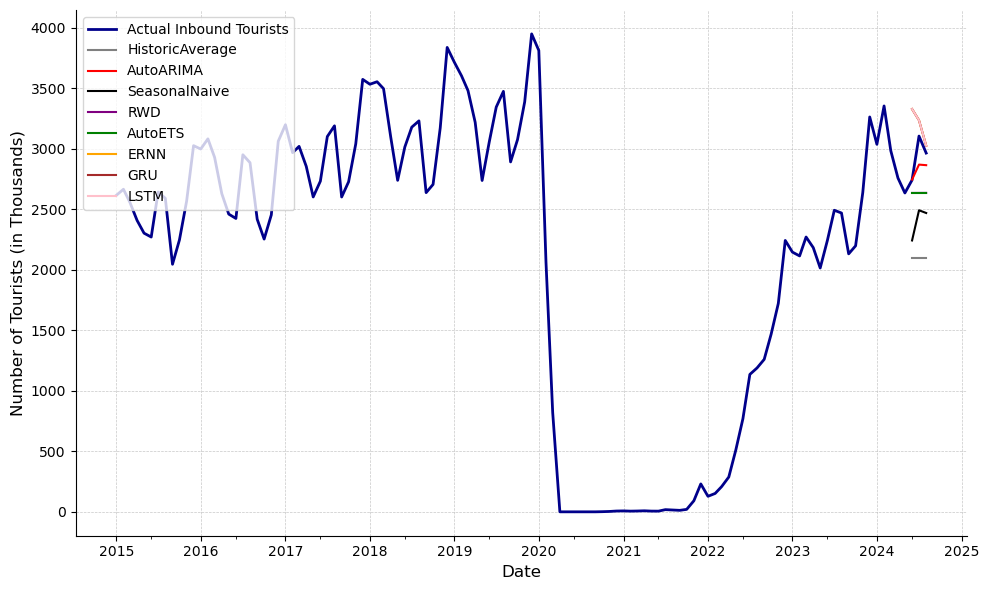

In [34]:
#| warning: false
#| echo: false
#| label: fig-forecast-plot
#| fig-cap: "Comparison of forecasted and actual inbound tourists"

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))


# Plot the original time series
ax.plot(th_tourists_set, color='darkblue', 
                        linewidth=2, label="Actual Inbound Tourists")

# Plot forecasts from different models
forecast_models = ["HistoricAverage", "AutoARIMA", "SeasonalNaive", 
                   "RWD", "AutoETS", "ERNN", "GRU", "LSTM"]
colors = ["gray", "red", "black", "purple", "green", "orange", "brown", "pink"]

for model, color in zip(forecast_models, colors):
    ax.plot(forecasts_df["ds"], forecasts_df[model], color=color, label=model)

# Formatting title and labels
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Number of Tourists (in Thousands)", fontsize=12)

# Set x-axis date formatting
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=6))  # Minor ticks at mid-year

# Rotate x-axis labels for better visibility
plt.xticks(fontsize=10)

# Add grid with subtle styling
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Remove top and right spines for a cleaner look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Add legend
ax.legend(fontsize=10, loc="upper left")

# Optimize layout
plt.tight_layout()

# Show the plot
plt.show()

## Conclusion

Given the growing importance of improving accuracy in forecasting tourist demand for the travel industry and policymakers, and the increasing interest in Neural Networks, this study demonstrates that RNN is effective for short-term forecasting of inbound tourist demand in Thailand. RNN outperforms benchmarks such as Historic Average, Seasonal Naïve, Random Walk with Drift and AutoETS, particularly in terms of SMAPE and MASE. The short length of the time series and its temporal patterns emphasize the importance of careful data preprocessing and hyperparameter optimization, which require specialized expertise and higher computational resources. Among the different RNN cell types, ERNN emerges as the most suitable option due to its simpler architecture, fewer parameters, and improved statistical properties, providing enhanced interpretability despite only marginal differences in performance across the evaluated metrics. However, traditional models such as AutoARIMA continue to demonstrate that simpler approaches often remain competitive when forecasting with limited observations and shorter horizons, similarly to the findings of Claveria et al. [-@claveria2014forecasting]. Nonetheless, the study's conclusions are constrained by its reliance on a single dataset, which limits the generalizability of the results. Future research should validate these findings by applying the methodology to additional datasets and assessing its performance across various contexts. Furthermore, future work should focus on refining data preprocessing techniques, experimenting with alternative ways for modelling trend and seasonality and optimizing hyperparameters, including testing other learning algorithms such as COCOB [@Orabona2017], as it is believed that RNN performance can be improved. A key limitation of RNN in this context is their inability to generate prediction intervals, which are crucial for assessing the uncertainty of forecasts. Future research should explore methods for generating prediction intervals to enhance the reliability of forecasts, which is particularly useful for budget allocation and strategic planning. Finally, expanding the analysis to multivariate forecasting by incorporating external variables alongside the target series could be explored to determine if predictive accuracy improves, especially when leveraging more advanced modeling techniques.

## References

::: {#refs}
:::